<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Session14_RCNN%26DenseDepth/dataCreation_Stats_and_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Necessary Packages

In [0]:
import cv2
import os
from google.colab.patches import cv2_imshow
from skimage import io
import glob
import random
import numpy as np
from tqdm.autonotebook import tqdm, trange
import time
import shutil
import matplotlib.pyplot as plt
from PIL import Image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [0]:

# Configuring paths
# Raw background images containing square images.
raw_bg = './raw_bg'
# Raw foreground images
raw_fg = './raw_fg'
# 200 * 200 size background images
bg_images = './bg'
# Foreground images.
fg_images = './fg'
# Background with foreground images.
bg_fg_images = './bg_fg'
# Mask images.
mask_images = './mask'
# Monocular depth images.
depth_images = './depth'


gdrive_path = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

In [0]:
pwd

'/content'

In [0]:
ls

sample_data/


## Get the necessary data from mounted drive

In [0]:
# Mask Images download
shutil.copy(os.path.join(gdrive_path,'mask.zip'),os.getcwd())

'/content/mask.zip'

In [0]:
!unzip -q mask.zip

In [0]:
os.remove('mask.zip')

In [0]:
# bg_fg images
shutil.copy(os.path.join(gdrive_path,'bg_fg.zip'),os.getcwd())

'/content/bg_fg.zip'

In [0]:
!unzip -q bg_fg.zip

In [0]:
os.remove('bg_fg.zip')

In [0]:
# Depth images
shutil.copy(os.path.join(gdrive_path,'depth.zip'),os.getcwd())

'/content/depth.zip'

In [0]:
!unzip -q depth.zip

In [0]:
os.remove('depth.zip')

In [0]:
shutil.copytree(os.path.join(gdrive_path,'fg'),"fg")

'fg'

In [0]:
shutil.copytree(os.path.join(gdrive_path,'bg'),"bg")

'bg'

## Data visualization

In [0]:
def display_horizontal(img_paths, img_name):
    # img = []
    # horizontal_concat = []
    it = 0
    margin = 8
    for img_path in img_paths:
        if it == 0:
            if img_name.split['.'][-1] == 'png':
                img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            else:
                img = cv2.imread(img_path)
            horizontal_concat = np.hstack((img, np.ones((img.shape[0], margin, img.shape[2]))*255))
        else:           
            if img_name.split['.'][-1] == 'png':
                img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            else:
                img = cv2.imread(img_path)
            horizontal_concat = np.hstack((horizontal_concat,img, np.ones((img.shape[0], margin, img.shape[2]))*255))
            # horizontal_concat = np.concatenate((horizontal_concat,img), axis = 1)
        it +=1
    cv2_imshow(horizontal_concat)
    cv2.imwrite(os.path.join(gdrive_path,'results',img_name), horizontal_concat)

### Background Images

In [0]:
bg_paths = glob.glob(os.path.join(bg_images,'*'))
bg_paths.sort()

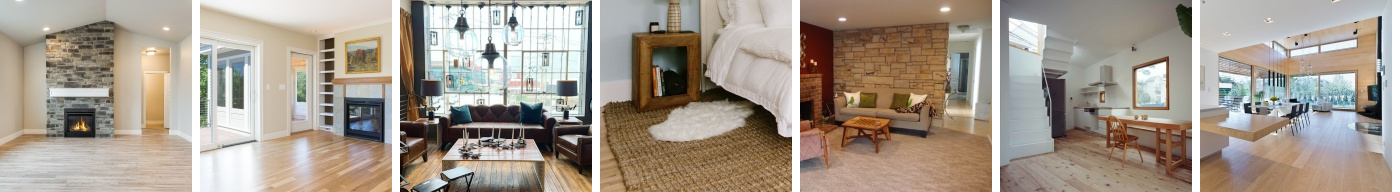

In [0]:
display_horizontal(bg_paths[10:17], 'bg.jpg')

### Foreground images

In [0]:
fg_paths = glob.glob(os.path.join(fg_images,'*'))
fg_paths.sort()

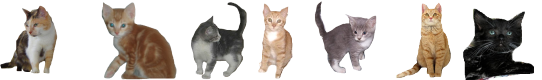

In [0]:
display_horizontal(fg_paths[20:27], 'fg.png')

Generate random indices for bg_fg, mask and depth images

In [0]:
# bg_fg images
bg_fg_paths = glob.glob(os.path.join(bg_fg_images,'*'))
bg_fg_paths.sort()
# mask images
mask_paths = glob.glob(os.path.join(mask_images,'*'))
mask_paths.sort()
# depth images
depth_paths = glob.glob(os.path.join(depth_images,'*'))
depth_paths.sort()

In [0]:
# To generate random images, lets take random indices between 0 to 2000.
rand_idx = [random.randint(0,40000) for i in range(7)]
print(rand_idx)

ov_img = []
ma_img = []
de_img = []
for z in rand_idx:
    ov_img.append(bg_fg_paths[z])
    ma_img.append(mask_paths[z])
    de_img.append(depth_paths[z])

[22089, 34114, 38524, 31972, 21494, 338, 27454]


### bg_fg images

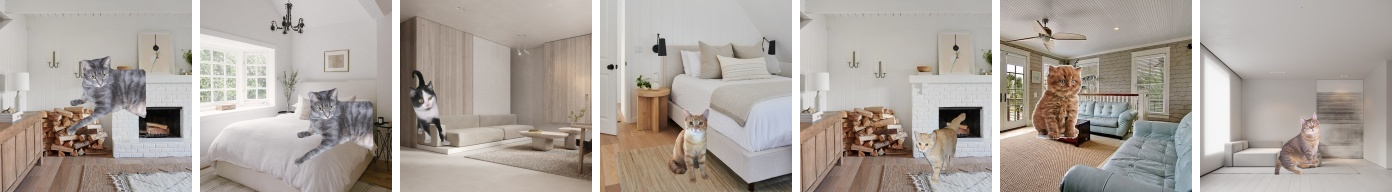

In [0]:
display_horizontal(ov_img, 'ov.jpg')

### Mask images

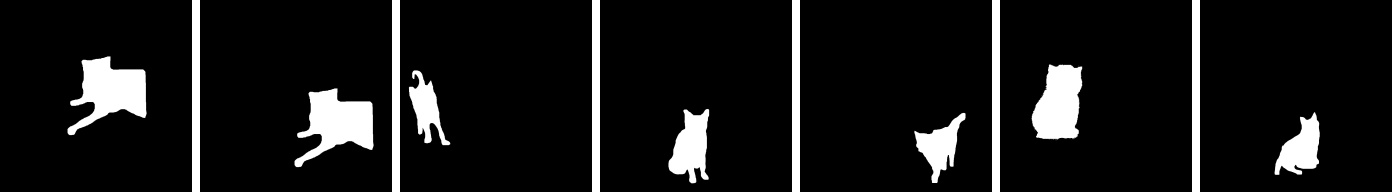

In [0]:
display_horizontal(ma_img, 'ma.jpg')

### Depth images

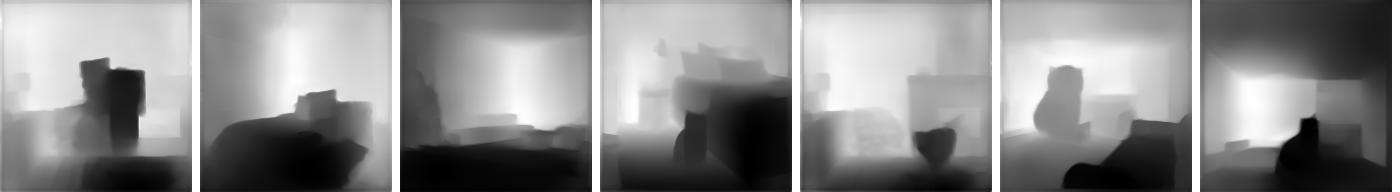

In [0]:
display_horizontal(de_img, 'de.jpg')

## Dataset statistics

In [0]:
def calculate_mean_std(image_path, number_channels):
    pixel_sum = 0
    channel_sum = np.zeros(number_channels)
    channel_squared_sum = np.zeros(number_channels)

    # As opencv reads data as 3 channels irrespective if its RGB or greyscale, adding read_flag
    if number_channels == 1:
        read_flag = 0
    elif number_channels == 3:
        read_flag = 1

    for path in tqdm(image_path):
        img = cv2.imread(path, read_flag)
        img = img/255
        pixel_sum += img.size/number_channels

        channel_sum += np.sum(img, axis=(0,1))
        channel_squared_sum += np.sum(np.square(img), axis=(0,1))

    bgr_mean = channel_sum/pixel_sum
    bgr_std = np.sqrt(channel_squared_sum/pixel_sum - np.square(bgr_mean))

    # bgr format to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]

    return rgb_mean, rgb_std

In [0]:
# mask mean, std calculation
mask_mean, mask_std = calculate_mean_std(mask_paths, 1)
print("Mean across 3 channels for mask images- ",mask_mean)
print("Std. Dev across 3 channels for mask images- ",mask_std)


Mean across 3 channels for mask images [0.06139549872557478]
Std. Dev across 3 channels for mask images [0.23733266587806698]


In [0]:
# bg_fg mean, std calculation
bg_fg_mean, bg_fg_std = calculate_mean_std(bg_fg_paths, 3)
print("Mean across 3 channels for bg_fg images", bg_fg_mean)
print("Std. Dev across 3 channels for bg_fg images", bg_fg_std)


Mean across 3 channels for bg_fg images [0.680840704152286, 0.6413480970394728, 0.5983284681579664]
Std. Dev across 3 channels for bg_fg images [0.1943246813923265, 0.21262046365551676, 0.23640705674849327]


In [0]:
# Depth mean, std calculation
depth_mean, depth_std = calculate_mean_std(depth_paths, 1)
print("Mean across 3 channels for depth images", depth_mean)
print("Std. Dev across 3 channels for depth images", depth_std)


Mean across 3 channels for depth images [0.4998136932492796]
Std. Dev across 3 channels for depth images [0.2729978042915119]
